In [80]:
##PART 1 : BUILDING MODEL WITH NUMPY ONLY

In [81]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist

In [82]:
def one_hot_encode(y, num_classes=10):
  one_hot = np.zeros((y.shape[0], num_classes))
  one_hot[np.arange(y.shape[0]), y] = 1
  return one_hot

In [83]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [84]:
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

In [85]:
Y_train = one_hot_encode(Y_train, 10)
Y_test = one_hot_encode(Y_test, 10)

In [86]:
print("shape of X_train: ", X_train.shape)
print("shape of Y_train: ", Y_train.shape)
print("shape of X_test: ", X_test.shape)
print("shape of Y_test: ", Y_test.shape)

shape of X_train:  (60000, 784)
shape of Y_train:  (60000, 10)
shape of X_test:  (10000, 784)
shape of Y_test:  (10000, 10)


In [87]:
def initialize_parameters_deep(layer_dims):
  np.random.seed(42)
  parameters = {}
  L = len(layer_dims)
  for l in range(1, L):
    parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
    parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
  return parameters


In [88]:
def Relu(Z):
  A = np.maximum(0, Z)
  cache = Z
  return A, cache

def Softmax(Z):
  e_z = np.exp(Z - np.max(Z, axis=0, keepdims = True))
  A = e_z / np.sum(e_z, axis=0, keepdims = True)
  cache = Z
  return A, cache

def linear_forward(A_prev, W, b):
  Z = np.dot(W, A_prev) + b
  cache = (A_prev, W, b)
  return Z, cache


In [89]:
def linear_activation_forward(A_prev, W, b, activation):
  if activation == "relu":
    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = Relu(Z)
  if activation == "softmax":
    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = Softmax(Z)
  cache = (linear_cache, activation_cache)
  return A, cache

In [90]:
def L_model_forward(X, parameters):
  caches = []
  A = X
  L = len(parameters) // 2
  for l in range(1, L):
    A_prev = A
    A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
    caches.append(cache)
  Al, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "softmax")
  caches.append(cache)
  return Al, caches


In [91]:
layer_dimensions = [784, 128, 10]
parameters = initialize_parameters_deep(layer_dimensions)
X_train_t = X_train.T
print("Shape of transposed X_train:", X_train_t.shape)

AL, caches = L_model_forward(X_train_t, parameters)
print("Shape of AL (final output):", AL.shape)
print("Number of caches stored:", len(caches))

Shape of transposed X_train: (784, 60000)
Shape of AL (final output): (10, 60000)
Number of caches stored: 2


In [92]:
def compute_cost(Al, Y):
  m = Y.shape[1]
  cost = -np.sum(np.multiply(Y, np.log(Al + 1e-8))) / m
  cost = np.squeeze(cost)
  return cost


In [93]:
def relu_backward(dA, cache):
  Z = cache
  dZ = np.array(dA, copy = True)
  dZ[Z <= 0] = 0
  return dZ

In [94]:
def softmax_backward(Al, Y):
  return Al - Y

In [95]:
def linear_backward(dZ, cache):
  A_prev, W, b = cache
  m = A_prev.shape[1]
  dW = (1/m)*np.dot(dZ, A_prev.T)
  db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
  dA_prev = np.dot(W.T, dZ)

  return dA_prev, dW, db

In [96]:
np.random.seed(1)

A_prev_tmp = np.random.randn(784, 2)
W_tmp = np.random.randn(128, 784)
b_tmp = np.random.randn(128, 1)
dZ_tmp = np.random.randn(128, 2)

Z_tmp, linear_cache_tmp = linear_forward(A_prev_tmp, W_tmp, b_tmp)
print("Created 'linear_cache_tmp' successfully.")
dA_prev_tmp, dW_tmp, db_tmp = linear_backward(dZ_tmp, linear_cache_tmp)

print("Shape of dA_prev: " + str(dA_prev_tmp.shape))
print("Shape of dW: " + str(dW_tmp.shape))
print("Shape of db: " + str(db_tmp.shape))

Created 'linear_cache_tmp' successfully.
Shape of dA_prev: (784, 2)
Shape of dW: (128, 784)
Shape of db: (128, 1)


In [97]:
def linear_activation_backward(dA, cache, Y, Al, activation):
  linear_cache, activation_cache = cache
  if activation == "relu":
    dZ = relu_backward(dA, activation_cache)
  elif activation == "softmax":
    dZ = softmax_backward(Al, Y)

  dA_prev, dW, db = linear_backward(dZ, linear_cache)

  return dA_prev, dW, db

In [98]:
def L_model_backward(Al, Y, caches):
  grads = {}
  L = len(caches)
  m = Al.shape[1]
  Y = Y.reshape(Al.shape)
  current_cache = caches[L-1]
  grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(None, current_cache, Y, Al, "softmax")
  for l in reversed(range(L-1)):
    current_cache = caches[l]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, None, None, "relu")
    grads["dA" + str(l)] = dA_prev_temp
    grads["dW" + str(l + 1)] = dW_temp
    grads["db" + str(l + 1)] = db_temp
  return grads


In [99]:
def update_parameters(parameters, grads, learning_rate):
  L = len(parameters) // 2
  for l in range(L):
    parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
    parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
  return parameters

In [100]:
import math
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
  np.random.seed(seed)
  m = X.shape[1]
  mini_batches = []
  permutation = list(np.random.permutation(m))
  shuffled_X = X[:, permutation]
  shuffled_Y = Y[:, permutation].reshape((Y.shape[0], m))

  num_complete_minibatches = math.floor(m/mini_batch_size)
  for k in range(0, num_complete_minibatches):
    mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
    mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)

  if (m % mini_batch_size != 0):
    mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size :]
    mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size :]
    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)
  return mini_batches

In [101]:
def L_layer_model(X, Y, layer_dims, learning_rate=0.0075, num_epochs=25, mini_batch_size=64, print_cost=False):
  np.random.seed(1)
  costs = []
  parameters = initialize_parameters_deep(layer_dims)
  for i in range(num_epochs):
    epoch_cost = 0
    minibatches = random_mini_batches(X, Y, mini_batch_size, seed=i)
    for minibatch in minibatches:
      (minibatch_X, minibatch_Y) = minibatch
      Al, caches = L_model_forward(minibatch_X, parameters)
      cost = compute_cost(Al, minibatch_Y)
      epoch_cost+=cost
      grads = L_model_backward(Al, minibatch_Y, caches)
      parameters = update_parameters(parameters, grads, learning_rate)

    epoch_cost/=len(minibatches)
    if print_cost and i % 5 == 0:
            print ("Cost after epoch %i: %f" %(i, epoch_cost))
    if print_cost and i % 5 == 0:
            costs.append(epoch_cost)
  return parameters, costs

In [102]:
import numpy as np

def predict_solution(X, parameters):

    Al, caches = L_model_forward(X, parameters)


    predictions = np.argmax(Al, axis=0)

    return predictions.reshape(1, -1)

In [103]:
X_train_t = X_train.T
Y_train_t = Y_train.T
X_test_t = X_test.T
Y_test_t = Y_test.T

In [104]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist


def one_hot_encode(y, num_classes=10):
  one_hot = np.zeros((y.shape[0], num_classes))
  one_hot[np.arange(y.shape[0]), y] = 1
  return one_hot


(X_train, Y_train_labels), (X_test, Y_test_labels) = fashion_mnist.load_data()


X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0


Y_train = one_hot_encode(Y_train_labels, 10)
Y_test = one_hot_encode(Y_test_labels, 10)


X_train_t = X_train.T
Y_train_t = Y_train.T
X_test_t = X_test.T
Y_test_t = Y_test.T


layer_dims = [784, 128, 10]

print("--- Data prepared successfully ---")
print(f"All variables including 'layer_dims' are now defined.")

--- Data prepared successfully ---
All variables including 'layer_dims' are now defined.


--- Training the model WITHOUT regularization ---
Cost after epoch 0: 1.617497
Cost after epoch 5: 0.717896
Cost after epoch 10: 0.611135
Cost after epoch 15: 0.560658
Cost after epoch 20: 0.529757
Cost after epoch 25: 0.508261


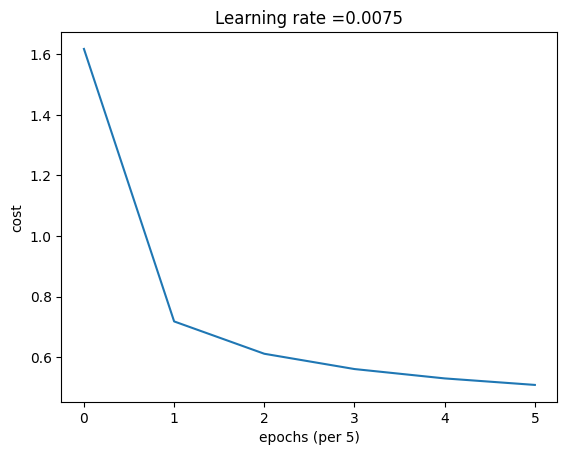


--- Evaluating the model ---
Accuracy on the training set: 83.43%
Accuracy on the test set: 82.44%


In [105]:
import matplotlib.pyplot as plt
print("--- Training the model WITHOUT regularization ---")

parameters, costs = L_layer_model(X_train_t, Y_train_t, layer_dims,
                                            learning_rate=0.001, num_epochs=30,
                                            mini_batch_size=64, print_cost=True)


plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('epochs (per 5)')
plt.title("Learning rate =" + str(0.0075))
plt.show()


print("\n--- Evaluating the model ---")

train_predictions = predict_solution(X_train_t, parameters)
train_labels = np.argmax(Y_train_t, axis=0).reshape(1, -1)
train_accuracy = np.mean(train_predictions == train_labels) * 100
print(f"Accuracy on the training set: {train_accuracy:.2f}%")


test_predictions = predict_solution(X_test.T, parameters)
test_labels = np.argmax(Y_test.T, axis=0).reshape(1, -1)
test_accuracy = np.mean(test_predictions == test_labels) * 100
print(f"Accuracy on the test set: {test_accuracy:.2f}%")

In [106]:
def compute_cost_with_regularization(Al, Y, parameters, lambd):
  m = Y.shape[1]
  cross_entropy_cost = compute_cost(Al, Y)
  L = len(parameters) // 2
  L2_regularization_cost = 0
  for l in range(1, L+1):
    W = parameters["W" + str(l)]
    L2_regularization_cost += np.sum(np.square(W))
  L2_regularization_cost = (lambd/(2*m))*L2_regularization_cost
  cost = cross_entropy_cost + L2_regularization_cost
  return cost


In [107]:
def linear_backward_with_regularization(dZ, cache, lambd):
  A_prev, W, b = cache
  m = A_prev.shape[1]
  dA_prev, dW, db = linear_backward(dZ, cache)
  dW += (lambd/m)*W
  return dA_prev, dW, db

In [108]:
def linear_activation_backward_with_reg(dA, cache, Y, Al, activation, lambd):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(Al, Y)

    dA_prev, dW, db = linear_backward_with_regularization(dZ, linear_cache, lambd)
    return dA_prev, dW, db

In [109]:
def L_model_backward_with_regularization(Al, Y, caches, lambd):
    grads = {}
    L = len(caches)
    Y = Y.reshape(Al.shape)
    current_cache = caches[L-1]

    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = \
        linear_activation_backward_with_reg(None, current_cache, Y, Al, "softmax", lambd)

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_input = grads["dA" + str(l + 1)]
        dA_prev_temp, dW_temp, db_temp = \
            linear_activation_backward_with_reg(dA_input, current_cache, None, None, "relu", lambd)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

def L_layer_model_regularized(X, Y, layer_dims, learning_rate=0.001, num_epochs=30,
                              mini_batch_size=64, lambd=0.1, print_cost=True):
    parameters = initialize_parameters_deep(layer_dims)
    costs = []

    for i in range(num_epochs):
        epoch_cost = 0.
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed=i)

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            Al, caches = L_model_forward(minibatch_X, parameters)

            cost = compute_cost_with_regularization(Al, minibatch_Y, parameters, lambd)
            epoch_cost += cost

            grads = L_model_backward_with_regularization(Al, minibatch_Y, caches, lambd)
            parameters = update_parameters(parameters, grads, learning_rate)

        epoch_cost /= len(minibatches)
        if print_cost and i % 5 == 0:
            print(f"Cost after epoch {i}: {epoch_cost}")
        if print_cost:
            costs.append(epoch_cost)

    return parameters, costs

In [110]:

print("--- Training Baseline Model ---")
params_base, costs_base = L_layer_model(X_train_t, Y_train_t, layer_dims,
                                                  learning_rate=0.001, num_epochs=30,
                                                  mini_batch_size=64, print_cost=True)


print("\n--- Training Regularized Model (lambd = 0.7) ---")
params_reg, costs_reg = L_layer_model_regularized(X_train_t, Y_train_t, layer_dims,
                                                  learning_rate=0.001, num_epochs=30,
                                                  lambd=0.1, print_cost=True)



--- Training Baseline Model ---
Cost after epoch 0: 1.617497
Cost after epoch 5: 0.717896
Cost after epoch 10: 0.611135
Cost after epoch 15: 0.560658
Cost after epoch 20: 0.529757
Cost after epoch 25: 0.508261

--- Training Regularized Model (lambd = 0.7) ---
Cost after epoch 0: 1.8340293095001354
Cost after epoch 5: 0.9392988525628384
Cost after epoch 10: 0.8337970651374674
Cost after epoch 15: 0.7834631171639042
Cost after epoch 20: 0.7521329487112918
Cost after epoch 25: 0.7298583416558013


In [111]:

print("--- Baseline Model Performance ---")
train_predictions_base = predict_solution(X_train_t, params_base)
train_labels = np.argmax(Y_train_t, axis=0).reshape(1, -1)
train_accuracy_base = np.mean(train_predictions_base == train_labels) * 100
print(f"Training Accuracy: {train_accuracy_base:.2f}%")

test_predictions_base = predict_solution(X_test.T, params_base)
test_labels = np.argmax(Y_test.T, axis=0).reshape(1, -1)
test_accuracy_base = np.mean(test_predictions_base == test_labels) * 100
print(f"Test Accuracy: {test_accuracy_base:.2f}%")
print(f"Overfitting Gap: {train_accuracy_base - test_accuracy_base:.2f}%")



print("\n--- Regularized Model Performance ---")
train_predictions_reg = predict_solution(X_train_t, params_reg)
train_accuracy_reg = np.mean(train_predictions_reg == train_labels) * 100
print(f"Training Accuracy: {train_accuracy_reg:.2f}%")

test_predictions_reg = predict_solution(X_test.T, params_reg)
test_accuracy_reg = np.mean(test_predictions_reg == test_labels) * 100
print(f"Test Accuracy: {test_accuracy_reg:.2f}%")
print(f"Overfitting Gap: {train_accuracy_reg - test_accuracy_reg:.2f}%")

--- Baseline Model Performance ---
Training Accuracy: 83.43%
Test Accuracy: 82.44%
Overfitting Gap: 0.99%

--- Regularized Model Performance ---
Training Accuracy: 83.31%
Test Accuracy: 82.37%
Overfitting Gap: 0.94%


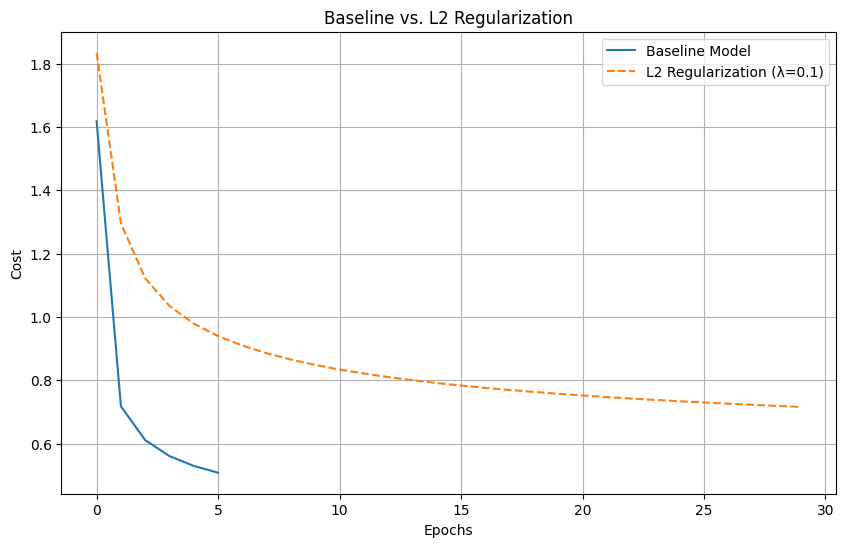

In [112]:
import matplotlib.pyplot as plt
import numpy as np



plt.figure(figsize=(10, 6))


plt.plot(np.squeeze(costs_base), label="Baseline Model")


plt.plot(np.squeeze(costs_reg), label="L2 Regularization (λ=0.1)", linestyle='--')

plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title("Baseline vs. L2 Regularization")
plt.legend()
plt.grid(True)


plt.savefig('regularization_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

In [113]:
def initialize_adam(parameters):
  L = len(parameters)//2
  v = {}
  s = {}
  for l in range(1, L+1):
    v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
    v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
    s["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
    s["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
  return v, s

In [114]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
  L = len(parameters) // 2
  v_corrected = {}
  s_corrected = {}
  for l in range(1, L+1):
    v["dW" + str(l)] = beta1*v["dW" + str(l)] + (1-beta1)*grads["dW"+str(l)]
    v["db" + str(l)] = beta1*v["db" + str(l)] + (1-beta1)*grads["db"+str(l)]
    v_corrected["dW" + str(l)] = v["dW" + str(l)]/(1-beta1**t)
    v_corrected["db" + str(l)] = v["db" + str(l)]/(1-beta1**t)

    s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * np.square(grads['dW' + str(l)])
    s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * np.square(grads['db' + str(l)])
    s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - beta2**t)
    s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - beta2**t)

    parameters["W" + str(l)] -= learning_rate*v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
    parameters["b" + str(l)] -= learning_rate*v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon)
  return parameters, v, s

In [115]:
def L_layer_model_adam(X, Y, layer_dims, learning_rate=0.001, num_epochs=30, mini_batch_size=64,
                         beta1=0.9, beta2=0.999, epsilon=1e-8, print_cost=True):

    costs = []
    t = 0

    parameters = initialize_parameters_deep(layer_dims)
    v, s = initialize_adam(parameters)


    for i in range(num_epochs):
        epoch_cost = 0.
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed=i)

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch

            Al, caches = L_model_forward(minibatch_X, parameters)
            cost = compute_cost(Al, minibatch_Y)
            epoch_cost += cost
            grads = L_model_backward(Al, minibatch_Y, caches)

            t += 1
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)

        epoch_cost /= len(minibatches)
        if print_cost and i % 5 == 0:
            print(f"Cost after epoch {i}: {epoch_cost}")
        if print_cost:
            costs.append(epoch_cost)

    return parameters, costs

--- Training Adam Optimizer Model ---
Cost after epoch 0: 0.5139693849281183
Cost after epoch 5: 0.2885271579846012
Cost after epoch 10: 0.23636590677551925
Cost after epoch 15: 0.20507882045865397
Cost after epoch 20: 0.1760010412837265
Cost after epoch 25: 0.15869346871887974


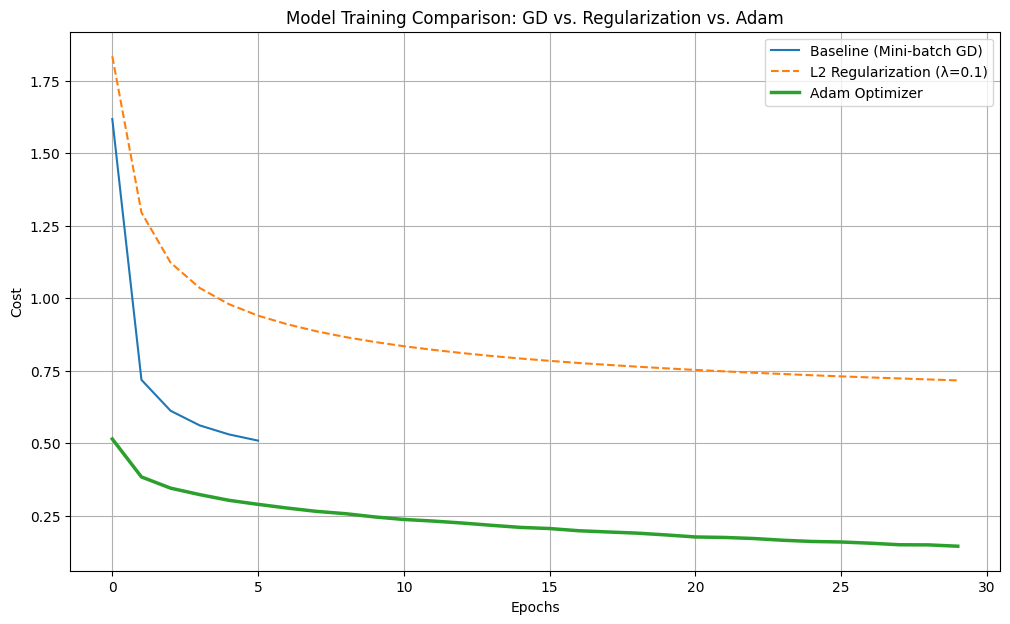


--- Adam Model Performance ---
Training Accuracy: 94.06%
Test Accuracy: 88.46%


In [116]:
import matplotlib.pyplot as plt


print("--- Training Adam Optimizer Model ---")
params_adam, costs_adam = L_layer_model_adam(X_train_t, Y_train_t, layer_dims,
                                             learning_rate=0.001, num_epochs=30,
                                             print_cost=True)


plt.figure(figsize=(12, 7))
plt.plot(np.squeeze(costs_base), label="Baseline (Mini-batch GD)")
plt.plot(np.squeeze(costs_reg), label="L2 Regularization (λ=0.1)", linestyle='--')
plt.plot(np.squeeze(costs_adam), label="Adam Optimizer", linewidth=2.5)

plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title("Model Training Comparison: GD vs. Regularization vs. Adam")
plt.legend()
plt.grid(True)


plt.savefig('final_model_comparison.png', dpi=300, bbox_inches='tight')

plt.show()


print("\n--- Adam Model Performance ---")
train_predictions_adam = predict_solution(X_train_t, params_adam)
train_labels = np.argmax(Y_train_t, axis=0).reshape(1, -1)
train_accuracy_adam = np.mean(train_predictions_adam == train_labels) * 100
print(f"Training Accuracy: {train_accuracy_adam:.2f}%")

test_predictions_adam = predict_solution(X_test.T, params_adam)
test_labels = np.argmax(Y_test.T, axis=0).reshape(1, -1)
test_accuracy_adam = np.mean(test_predictions_adam == test_labels) * 100
print(f"Test Accuracy: {test_accuracy_adam:.2f}%")

In [117]:
##PART 2: BUILDING MODEL WITH TENSORFLOW

In [118]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

print("Data loaded and prepared for TensorFlow.")
print("Shape of training images:", x_train.shape)
print("Shape of training labels:", y_train.shape)

Data loaded and prepared for TensorFlow.
Shape of training images: (60000, 28, 28)
Shape of training labels: (60000,)


In [119]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [121]:

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_test, y_test)
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7805 - loss: 0.6346 - val_accuracy: 0.8541 - val_loss: 0.4194
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8611 - loss: 0.3884 - val_accuracy: 0.8585 - val_loss: 0.3994
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8749 - loss: 0.3377 - val_accuracy: 0.8723 - val_loss: 0.3629
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8863 - loss: 0.3135 - val_accuracy: 0.8626 - val_loss: 0.3753
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8908 - loss: 0.2940 - val_accuracy: 0.8659 - val_loss: 0.3729
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8958 - loss: 0.2814 - val_accuracy: 0.8708 - val_loss: 0.3601
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9024 - loss: 0.2640 - val_accuracy: 0.8758 - val_loss: 0.3406
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9041 - loss: 0.2577 -

In [122]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - 2ms/step - accuracy: 0.8828 - loss: 0.3397

Test accuracy: 0.8827999830245972


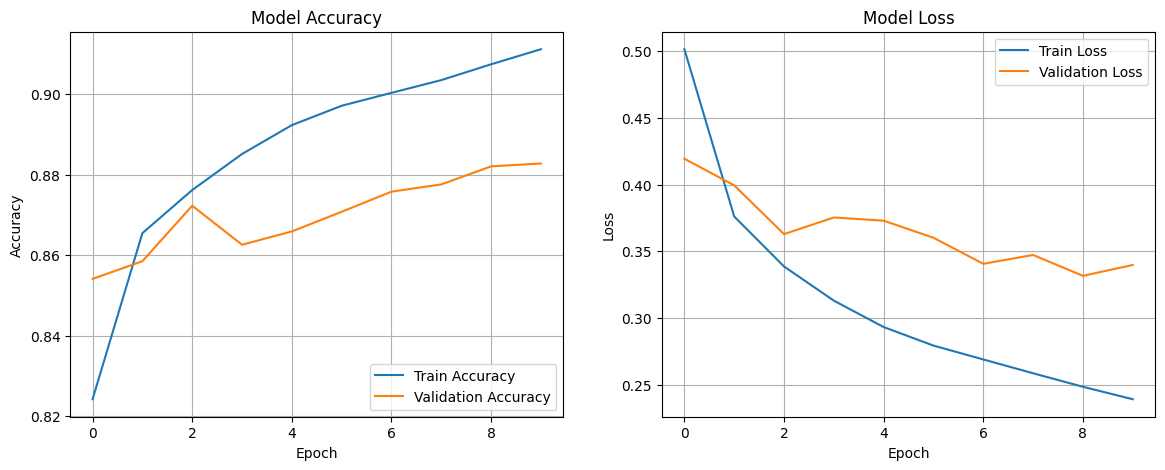

In [123]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower right')
ax1.grid(True)


ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')
ax2.grid(True)


plt.savefig('tensorflow_training_history.png', dpi=300, bbox_inches='tight')

plt.show()

In [124]:
import tensorflow as tf


regularized_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),


    tf.keras.layers.Dense(128,
                          activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),


    tf.keras.layers.Dropout(0.2),


    tf.keras.layers.Dense(10)
])

regularized_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


history_regularized = regularized_model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_test, y_test)
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7559 - loss: 0.8482 - val_accuracy: 0.8370 - val_loss: 0.5482
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8389 - loss: 0.5473 - val_accuracy: 0.8381 - val_loss: 0.5337
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8442 - loss: 0.5114 - val_accuracy: 0.8468 - val_loss: 0.5059
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8462 - loss: 0.5082 - val_accuracy: 0.8462 - val_loss: 0.5026
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8497 - loss: 0.4947 - val_accuracy: 0.8521 - val_loss: 0.4792
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8534 - loss: 0.4882 - val_accuracy: 0.8392 - val_loss: 0.5061
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8527 - loss: 0.4868 - val_accuracy: 0.8513 - val_loss: 0.4883
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8509 - loss: 0.4

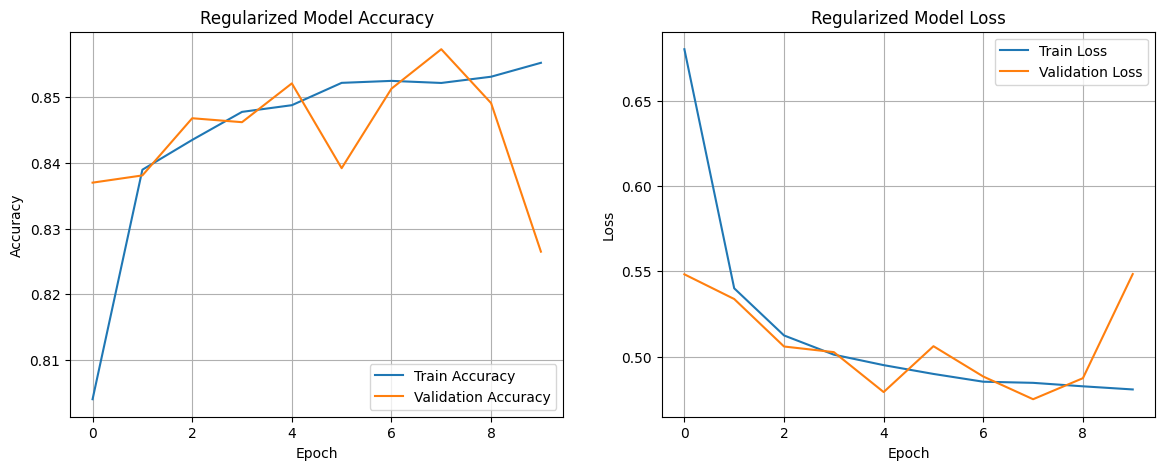

In [125]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


ax1.plot(history_regularized.history['accuracy'], label='Train Accuracy')
ax1.plot(history_regularized.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Regularized Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower right')
ax1.grid(True)


ax2.plot(history_regularized.history['loss'], label='Train Loss')
ax2.plot(history_regularized.history['val_loss'], label='Validation Loss')
ax2.set_title('Regularized Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')
ax2.grid(True)


plt.savefig('tensorflow_regularized_history.png', dpi=300, bbox_inches='tight')

plt.show()